# Installation and import of libraries

In [137]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
!pip install -U spacy
!python -m spacy download en_core_web_md

2024-01-07 21:42:18.796458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 21:42:18.796520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 21:42:18.798242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 21:42:21.751429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 7.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as P
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
import csv
from sklearn.utils import shuffle
from tensorflow.keras import preprocessing
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split


# Loading data

Loading data containing the content of SMS messages and labeled whether they are spam or not.

In [140]:
data=pd.read_csv(r'/content/train.csv')
data.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Size of the data.

In [141]:
data.shape


(5574, 2)

The type of data and size in memory.

In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


We count how many different values there are in each column, first using the groupby method to group the data by label column to see how many classes there are in the set.

In [143]:
data.groupby('label').nunique()

,sms
label,
0,4518
1,653


Checking the distribution of the data

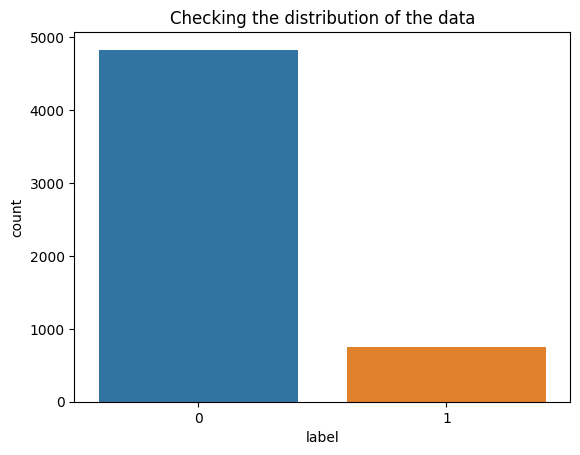

In [144]:
sns.countplot(x='label', data=pd.DataFrame(data)).set_title('Checking the distribution of the data')
P.show()

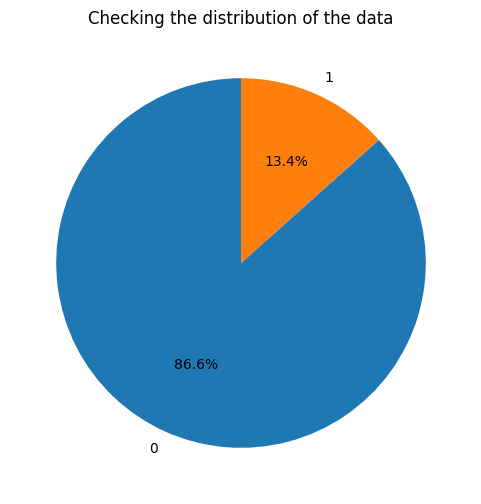

In [145]:
P.figure(figsize=(6, 6))
P.pie(data['label'].value_counts(), labels=data['label'].unique(), autopct='%1.1f%%', startangle=90)
P.title('Checking the distribution of the data')
P.show()

Conclusion : It can be seen that 13.4% are labeled as spam in the SMS text data set (train.csv)

I display some random examples from each class

In [146]:
data[data['label']==0].sample(5)

,sms,label
3281,Badrith is only for chennai:)i will surely pic...,0
4518,"Men always needs a beautiful, intelligent, car...",0
1768,"K, want us to come by now?\n",0
665,Yes baby! We can study all the positions of th...,0
3271,K actually can you guys meet me at the sunoco ...,0


In [147]:
data[data['label']==1].sample(5)

,sms,label
5542,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,1
5549,Had your contract mobile 11 Mnths? Latest Moto...,1
4888,Todays Vodafone numbers ending with 4882 are s...,1
123,Todays Voda numbers ending 7548 are selected t...,1
2663,Hello darling how are you today? I would love ...,1


# Preprocessing

In [148]:
data.rename(columns={'sms': 'text'}, inplace=True)
data.sample(2)

,text,label
778,"""Hi its Kate it was lovely to see you tonight ...",0
4785,Indeed and by the way it was either or - not b...,0


Conversion of all sms texts in the text column to lowercase letters.

In [149]:
data['text'] = data['text'].apply(lambda x: x.lower())
data.sample(5)

,text,label
575,nope i waiting in sch 4 daddy... \n,0
4510,ü takin linear algebra today?\n,0
905,"we're all getting worried over here, derek and...",0
225,"500 new mobiles from 2004, must go! txt: nokia...",1
4999,can you talk with me..\n,0


Removal of all URLs from sms text

In [150]:
re_url = re.compile(r"((www.[^\s]+)|(https?://[^\s]+))")

data['text'] = data['text'].apply(lambda x: re_url.sub('', x))

Removal of characters from the text except: letters of the alphabet, whitespace characters (class \s) and apostrophe ' (this is about English abbreviation, e.g. don't or isn't).

In [151]:
re_letters = re.compile(r"[^a-z\s']")

data['text'] = data['text'].apply(lambda x: re_letters.sub('', x))
data.sample(5)

,text,label
1606,when you came to hostel\n,0
5554,have a safe trip to nigeria wish you happiness...,0
5346,when you guys planning on coming over\n,0
3681,i cant pick the phone right now pls send a mes...,0
24,ffffffffff alright no way i can meet up with y...,0


Load en_core_web_md model from spacy library.

In [152]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])

Removal of stop words

In [153]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['text'] = data['text'].apply(remove_stopwords)
data.sample(5)

,text,label
2599,okie thanx,0
3037,ok feel like john lennon,0
5363,yep program you're slacking,0
2440,rightio arent bright early morning,0
2924,fine simply sitting,0


Removal of duplicates

In [154]:
data.drop_duplicates(subset='text', keep='first', inplace=True)

Lemantization

In [155]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data['text'] = data['text'].progress_apply(lemmatize)
data.sample(5)

100%|██████████| 5048/5048 [00:52<00:00, 96.39it/s] 


,text,label
575,nope wait sch daddy,0
710,mth half price orange line rental late camera ...,1
3161,ur hdd casing cost,0
5519,mile smile r frm letters u know d difference s...,0
4589,want wish happy new year want talk legal advic...,0


# Word clouds

Display the most popular words from each group

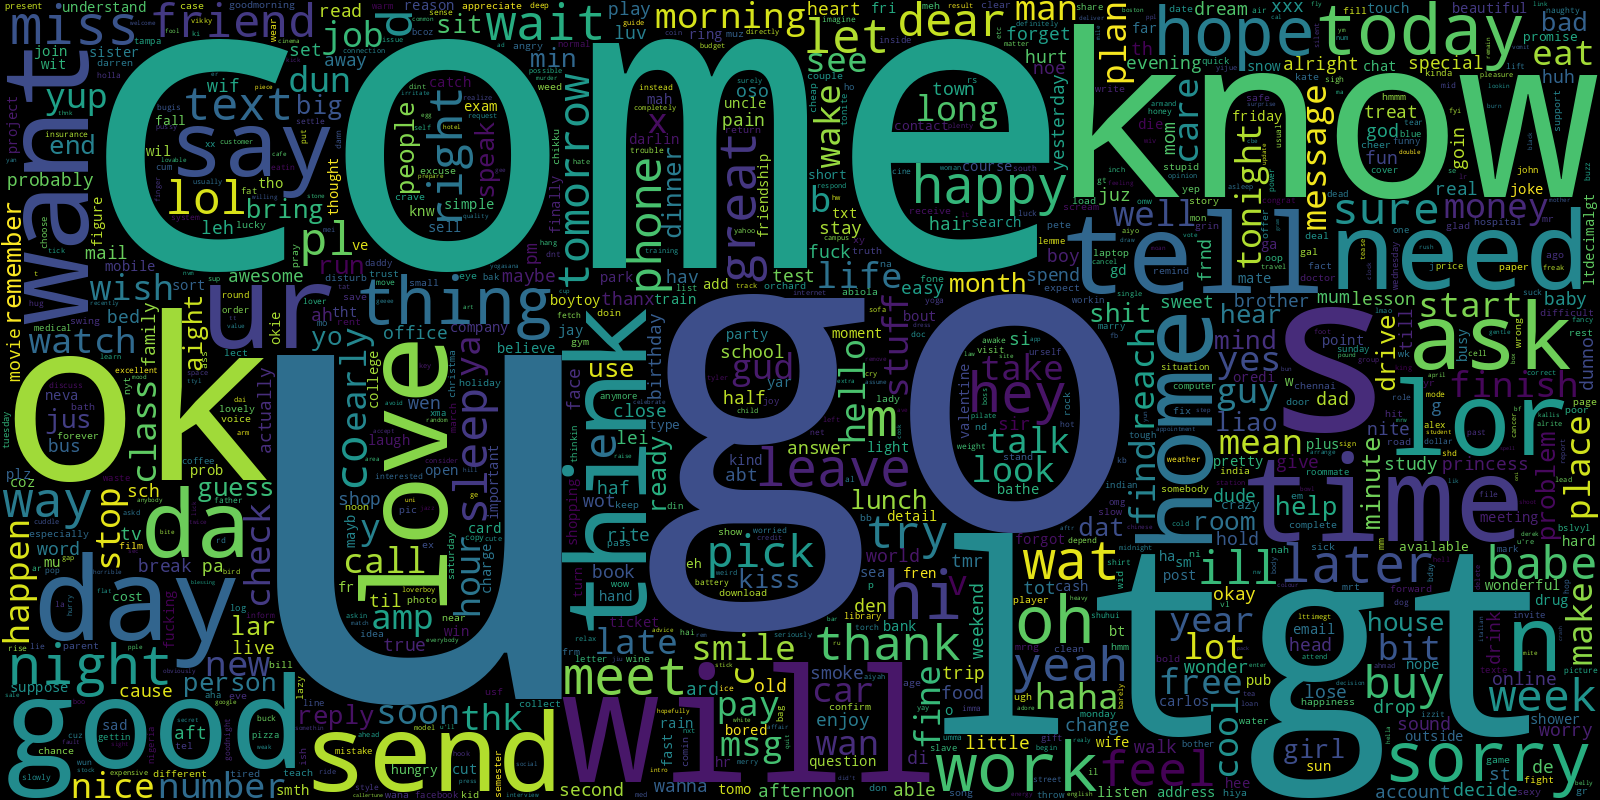

In [156]:
not_spam = ' '.join(data[data['label']==0]['text'])

wc_neg = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(not_spam)
wc_neg.to_image()

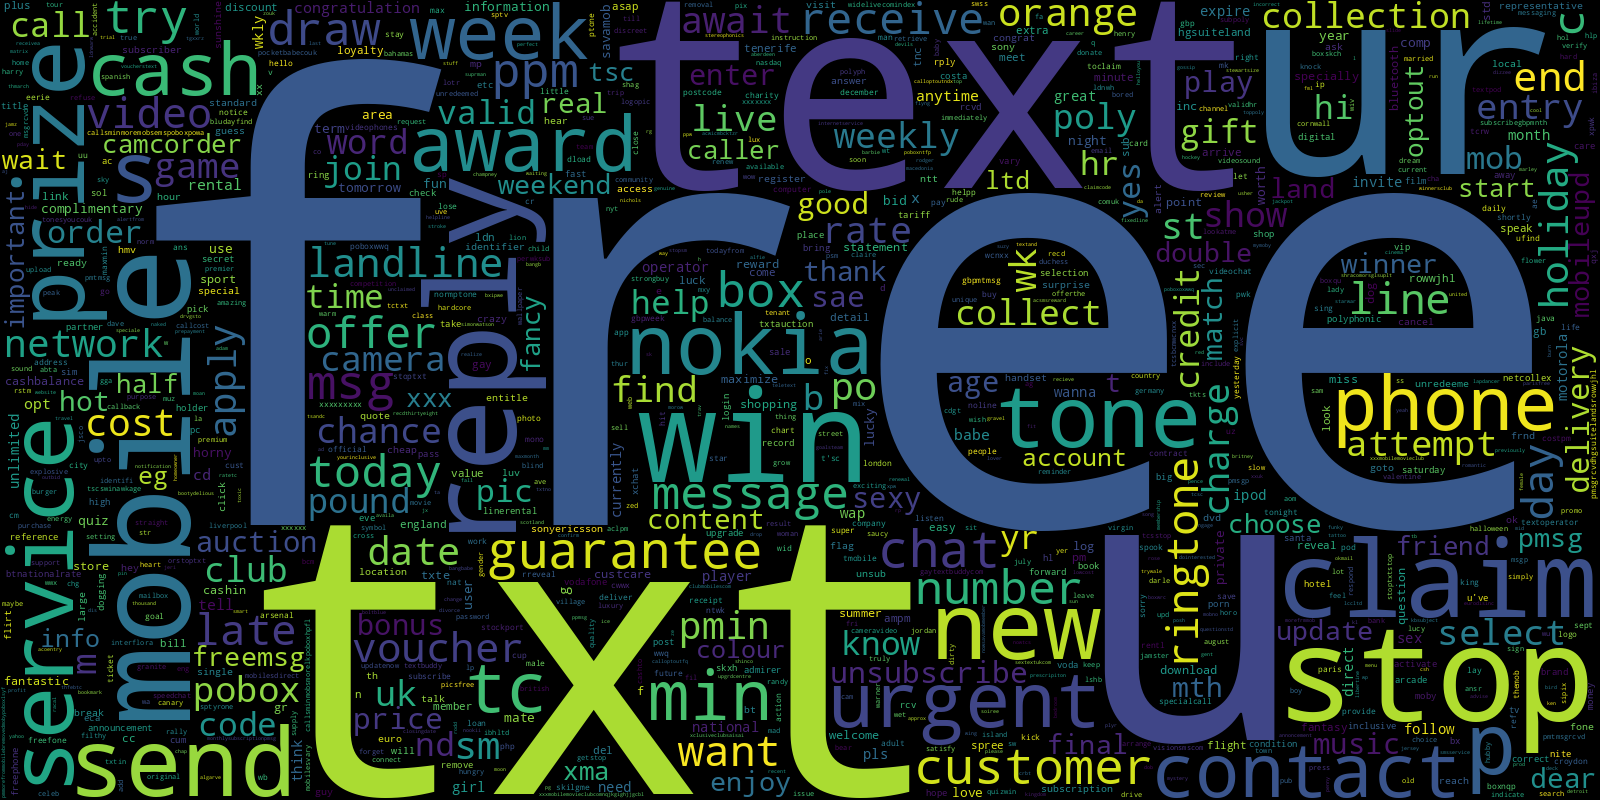

In [157]:
spam = ' '.join(data[data['label']==1]['text'])

wc_pos = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(spam)
wc_pos.to_image()

For pythorch models export clean data, which I will use later

In [158]:
data.to_csv('train_clean.csv', index=False)

# Tensorflow library was used for the LSTM and CNN models presented below

# LSTM Model

In [159]:
data['label'].value_counts()
text =[]


for index, rows in data.iterrows():

    my_list =str(rows.text)
    text.append(my_list)


len(text)

5048

Preparation of SMS text data for use in the LSTM model by tokenizing and transforming them into sequences of numbers and adjusting them to a uniform length

In [160]:
label = list(data['label'])
maxlen1 = 20
tokenizer1 = Tokenizer(num_words=1000)
tokenizer1.fit_on_texts(text)
sequences1 = tokenizer1.texts_to_sequences(text)
x_data = sequence.pad_sequences(sequences1, maxlen=maxlen1)
y_data = np.array(label)

Split data into training and test data

In [161]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

Training a recursive LSTM (Long Short-Term Memory) model for binary text classification with three main layers: Embedding (2000 words, dimension 8), LSTM (32 units), and Dense (1 unit with sigmoid activation function). The model is compiled with 'rmsprop' optimizer, 'binary_crossentropy' loss function (for binary classification), and accuracy metric. It is trained for 10 epochs with a batch size of 32, and 20% of the training data is used as a validation set.

In [162]:
model1 = Sequential()
model1.add(Embedding(2000, 8, input_length=maxlen1))
model1.add(LSTM(32))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model1.summary()

history = model1.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 8)             16000     
                                                                 
 lstm_4 (LSTM)               (None, 32)                5248      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21281 (83.13 KB)
Trainable params: 21281 (83.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
101/101 [==============================] - 55s 41ms/step - loss: 0.3520 - acc: 0.8851 - val_loss: 0.2847 - val_acc: 0.8663
Epoch 2/10
101/101 [==============================] - 2s 23ms/step - loss: 0.2007 - acc: 0.9204 - val_loss: 0.2153 - val_acc: 0.9629
Epoch 3/10
101/

In [163]:
result=model1.evaluate(x_test,y_test)
print("test loss:{}\ntest accuracy:{}".format(result[0],result[1]))

32/32 [==============================] - 0s 3ms/step - loss: 0.0676 - acc: 0.9812
test loss:0.06761708855628967
test accuracy:0.9811881184577942



Function  designed to classify whether a given input text is spam or not using a trained LSTM model for text classification.

In [166]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

def is_spam_or_not(input_text, model1, tokenizer1, maxlen1):

    input_sequence = tokenizer1.texts_to_sequences([input_text])
    padded_input = sequence.pad_sequences(input_sequence, maxlen=maxlen1)

    prediction = model1.predict(padded_input)

    result = "Spam" if prediction > 0.5 else "Not Spam"
    confidence = prediction[0, 0] if result == "Spam" else 1 - prediction[0, 0]

    return result, confidence


input_text = "Congratulations! You've won a free iPhone. Claim it now!"
result, confidence = is_spam_or_not(input_text, model1, tokenizer1, maxlen1)
print(f"The input is {result} with confidence {confidence}")


1/1 [==============================] - 1s 1s/step
The input is Spam with confidence 0.9681960940361023


# CNN Model

Preparation of data for use in the CNN model. Parameters such as maximum sequence length (maxlen), embedding dimension (embedding_dim) and maximum number of words (max_words) are defined. The text is then tokenized and the sequences are completed or shortened to the specified length.

In [167]:
maxlen2 = 20
embedding_dim = 50
max_words = 10000

tokenizer2 = Tokenizer(num_words=max_words)
tokenizer2.fit_on_texts(text)
sequences2 = tokenizer2.texts_to_sequences(text)
x = sequence.pad_sequences(sequences2, maxlen=maxlen2)

This CNN model is used for binary text classification. It starts with an embedding layer that transforms words into vectors of a certain dimension. It then includes two convolutional layers with ReLU activation function to help detect local features in the sequence. In between are max pooling layers that reduce the dimensionality of the data. Global max pooling is used to get a global representation of the features. Finally, there is a dense layer with one neuron and a sigmoidal activation function, predicting binary classification.

In [168]:
cnn_model = Sequential()
cnn_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
cnn_model.add(Conv1D(32, 5, activation='relu'))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Conv1D(64, 3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [169]:
cnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
cnn_model.summary()

history_cnn = cnn_model.fit(x_train, y_train,
                            epochs=10,
                            batch_size=32,
                            validation_split=0.2)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 50)            500000    
                                                                 
 conv1d_4 (Conv1D)           (None, 16, 32)            8032      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 3, 32)             0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_7 (Dense)             (None, 1)                

In [170]:
result_cnn = cnn_model.evaluate(x_test, y_test)
print("CNN Model - Test loss: {}\nTest accuracy: {}".format(result_cnn[0], result_cnn[1]))


32/32 [==============================] - 0s 3ms/step - loss: 0.1036 - acc: 0.9743
CNN Model - Test loss: 0.10361968725919724
Test accuracy: 0.9742574095726013


In [171]:
def is_spam_or_not_cnn(input_text, cnn_model, tokenizer2, maxlen2):

    input_sequence = tokenizer2.texts_to_sequences([input_text])
    padded_input = sequence.pad_sequences(input_sequence, maxlen=maxlen2)

    prediction = cnn_model.predict(padded_input)

    result = "Spam" if prediction > 0.5 else "Not Spam"
    confidence = prediction[0, 0] if result == "Spam" else 1 - prediction[0, 0]

    return result, confidence

input_text_cnn = "Congratulations! You've won a free iPhone. Claim it now!"
result_cnn, confidence_cnn = is_spam_or_not_cnn(input_text_cnn, cnn_model, tokenizer2, maxlen2)
print(f"The input is {result_cnn} with confidence {confidence_cnn}")

1/1 [==============================] - 0s 67ms/step
The input is Spam with confidence 0.9997394680976868


# The pytorch library was used to train the following model

# Model with a base of pre-trained word embeddings

Seed (seed) settings to ensure repeatable results when using the GPU.

In [217]:
import torch

SEED = 42

torch.manual_seed(SEED)
if torch.cuda.is_available():
 torch.cuda.manual_seed(SEED)
 torch.cuda.manual_seed_all(SEED)
 torch.backends.cudnn.deterministic = True
 torch.backends.cudnn.benchmark = False

Transformers library installation

In [203]:
!pip install -U transformers -q

In [218]:
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import time
import csv

In [219]:
def read_tsv(filename):
 data = []

 with open(filename, 'r', encoding='utf-8') as f:
  reader = csv.reader(f, delimiter=',')
  for row in reader:
    data.append(tuple(row))

 return data

filename = "train_clean.csv"
data_list = read_tsv(filename)
data_list[0]

('text', 'label')

Divides the clean data list (data_list) into training and test sets

In [220]:
split_ratio = 0.2
n_train = len(data_list)
n_test = int(n_train * split_ratio)
n_train = n_train - n_test
train_data, test_data = random_split(data_list, [n_train, n_test])

Definition of label_pipeline and collate_batch,

In [221]:
label_pipeline = lambda x: 1 if x == '1' else 0

def collate_batch(batch):
 label_list, text_list = [], []
 for (_text, _label) in batch:
  label_list.append(label_pipeline(_label))
  text_list.append(_text)
 return torch.tensor(label_list, dtype=torch.float32), text_list

Creation of dataloaders

In [222]:
batch_size = 64

val_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

Creating a device object in PyTorch, which will be used to store tensors.

In [223]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A Recurrent Neural Network (RNN) class in PyTorch has been defined, which uses pre-trained word embedding (BERT DistilBERT) substitution to embed text, and then passes it through a recurrent layer (RNN) and a dense layer (linear layer) for spam classification.

In [224]:
import torch

class RNN(nn.Module):

  def __init__(self, hidden_dim, output_dim):
    super().__init__()

    self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

    embedding_dim = self.distilbert.config.hidden_size

    self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, text, text_length=None):
    inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512, return_length=True)
    attention_mask = inputs['attention_mask'].to(device)
    input_ids = inputs['input_ids'].to(device)

    with torch.no_grad():
      embedded = self.distilbert(input_ids, attention_mask=attention_mask).last_hidden_state

    outputs, hidden = self.rnn(embedded)
    return self.fc(hidden.squeeze(0))

In [225]:
hidden_dim = 256
output_dim = 1

model = RNN(hidden_dim, output_dim)

Count the total number of parameters in the PyTorch model that are trainable

In [226]:
def count_parameters(model):
 return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Model ma {count_parameters(model):,} parametrów')

Model ma 66,625,793 parametrów


Configuration of the optimizer (optimizer) and loss function (criterion) for the model in the context of a classification task.

In [227]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

This code defines auxiliary functions for training and evaluating a binary classification model, as well as for calculating binary accuracy.

In [228]:
def binary_accuracy(preds, y):
  rounded_preds = torch.round(torch.sigmoid(preds))
  correct = (rounded_preds == y).float()
  acc = correct.sum() / len(correct)
  return acc

def train(model, iterator, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.train()

  for batch in iterator:
    labels, texts = batch
    labels = labels.to(device)
    optimizer.zero_grad()

    predictions = model(texts).squeeze(1)
    loss = criterion(predictions, labels)
    acc = binary_accuracy(predictions, labels)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()

  with torch.no_grad():
    for batch in iterator:
      labels, texts = batch
      labels = labels.to(device)

      predictions = model(texts).squeeze(1)
      loss = criterion(predictions, labels)
      acc = binary_accuracy(predictions, labels)

      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

I trained the model using the training data, evaluated it on the validation data and saved the best version of the model in the 'rnn-model.pt' file.

In [229]:
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'rnn-model.pt')

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.535 | Train Acc: 88.06%
	 Val. Loss: 0.469 | Val. Acc: 88.14%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.424 | Train Acc: 88.50%
	 Val. Loss: 0.402 | Val. Acc: 88.14%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.382 | Train Acc: 88.33%
	 Val. Loss: 0.372 | Val. Acc: 88.14%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.359 | Train Acc: 88.50%
	 Val. Loss: 0.358 | Val. Acc: 88.14%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.347 | Train Acc: 88.50%
	 Val. Loss: 0.349 | Val. Acc: 88.14%


Function for model validation in spam detection


In [235]:
def predict_spam(sentence, model, device):
    model.eval()


    inputs = model.tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512, return_length=True)
    attention_mask = inputs['attention_mask'].to(device)
    input_ids = inputs['input_ids'].to(device)

    with torch.no_grad():
        embedded = model.distilbert(input_ids, attention_mask=attention_mask).last_hidden_state


    outputs, hidden = model.rnn(embedded)
    logits = model.fc(hidden.squeeze(0))


    probabilities = torch.sigmoid(logits)

    is_spam = probabilities.item() > 0.5

    return is_spam, probabilities.item()


sentence_to_check = "This is a normal sentence."
is_spam, probability = predict_spam(sentence_to_check, model, device)

print(f"The sentence '{sentence_to_check}' is {'spam' if is_spam else 'not spam'} ")


The sentence 'This is a normal sentence.' is not spam 
